## ACTIVITY 2

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import torch
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
torch.manual_seed(0)

In [2]:
data = pd.read_csv("dccc_prepared.csv")
data.head()

,LIMIT_BAL,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,0.080808,0.333333,0.666667,0.224138,0.2,0.2,0.2,0.2,0.2,0.2,...,0.173637,0.095470,0.272928,0.001738,0.000891,0.001116,0.001610,0.002345,0.009458,0
1,0.040404,0.333333,0.333333,0.275862,0.2,0.2,0.2,0.2,0.2,0.2,...,0.186809,0.109363,0.283685,0.002290,0.001199,0.001339,0.001771,0.002506,0.001892,0
2,0.040404,0.333333,0.333333,0.620690,0.1,0.2,0.1,0.2,0.2,0.2,...,0.179863,0.099633,0.275681,0.002290,0.021779,0.011160,0.014493,0.001615,0.001284,0
3,0.040404,0.166667,0.666667,0.275862,0.2,0.2,0.2,0.2,0.2,0.2,...,0.178407,0.100102,0.276367,0.002862,0.001078,0.000733,0.001610,0.002345,0.001513,0
4,0.494949,0.166667,0.666667,0.137931,0.2,0.2,0.2,0.2,0.2,0.2,...,0.671310,0.559578,0.625196,0.062961,0.023749,0.042409,0.032591,0.032237,0.026047,0


In [3]:
X = data.iloc[:,:-1]
y = data["default payment next month"]

In [4]:
X_new, X_test, y_new, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
dev_per = X_test.shape[0]/X_new.shape[0]
X_train, X_dev, y_train, y_dev = train_test_split(X_new, y_new, test_size=dev_per, random_state=0)

In [5]:
X_dev_torch = torch.tensor(X_dev.values).float()
y_dev_torch = torch.tensor(y_dev.values)
X_test_torch = torch.tensor(X_test.values).float()
y_test_torch = torch.tensor(y_test.values)

### First fine-tuning approach

In [6]:
class Classifier(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.hidden_1 = nn.Linear(input_size, 10)
        self.hidden_2 = nn.Linear(10, 10)
        self.hidden_3 = nn.Linear(10, 10)
        self.output = nn.Linear(10, 2)
        
    def forward(self, x):
        z = F.relu(self.hidden_1(x))
        z = F.relu(self.hidden_2(z))
        z = F.relu(self.hidden_3(z))
        out = F.log_softmax(self.output(z), dim=1)
        
        return out

In [7]:
model = Classifier(X_train.shape[1])
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 1000
batch_size = 128

In [8]:
train_losses, dev_losses, train_acc, dev_acc= [], [], [], []
x_axis = []

for e in range(1,epochs+1):
    X_, y_ = shuffle(X_train, y_train)
    running_loss = 0
    running_acc = 0
    iterations = 0
    
    for i in range(0, len(X_), batch_size):
        iterations += 1
        b = i + batch_size
        X_batch = torch.tensor(X_.iloc[i:b,:].values).float()
        y_batch = torch.tensor(y_.iloc[i:b].values)
        
        log_ps = model(X_batch)
        loss = criterion(log_ps, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        running_acc += accuracy_score(y_batch, top_class)
        
    dev_loss = 0
    acc = 0

    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        log_dev = model(X_dev_torch)
        dev_loss = criterion(log_dev, y_dev_torch)

        ps_dev = torch.exp(log_dev)
        top_p, top_class_dev = ps_dev.topk(1, dim=1)
        acc = accuracy_score(y_dev_torch, top_class_dev)

    if e%50 == 0 or e == 1:
        x_axis.append(e)
        
        train_losses.append(running_loss/iterations)
        dev_losses.append(dev_loss)
        train_acc.append(running_acc/iterations)
        dev_acc.append(acc)
        
        print("Epoch: {}/{}.. ".format(e, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/iterations),
              "Validation Loss: {:.3f}.. ".format(dev_loss),
              "Training Accuracy: {:.3f}.. ".format(running_acc/iterations),
              "Validation Accuracy: {:.3f}".format(acc))

Epoch: 1/1000..  Training Loss: 0.671..  Validation Loss: 0.628..  Training Accuracy: 0.576..  Validation Accuracy: 0.639
Epoch: 50/1000..  Training Loss: 0.558..  Validation Loss: 0.567..  Training Accuracy: 0.713..  Validation Accuracy: 0.710
Epoch: 100/1000..  Training Loss: 0.552..  Validation Loss: 0.563..  Training Accuracy: 0.717..  Validation Accuracy: 0.704
Epoch: 150/1000..  Training Loss: 0.550..  Validation Loss: 0.561..  Training Accuracy: 0.719..  Validation Accuracy: 0.706
Epoch: 200/1000..  Training Loss: 0.546..  Validation Loss: 0.562..  Training Accuracy: 0.722..  Validation Accuracy: 0.706
Epoch: 250/1000..  Training Loss: 0.545..  Validation Loss: 0.558..  Training Accuracy: 0.722..  Validation Accuracy: 0.711
Epoch: 300/1000..  Training Loss: 0.545..  Validation Loss: 0.557..  Training Accuracy: 0.721..  Validation Accuracy: 0.714
Epoch: 350/1000..  Training Loss: 0.542..  Validation Loss: 0.558..  Training Accuracy: 0.726..  Validation Accuracy: 0.710
Epoch: 400/

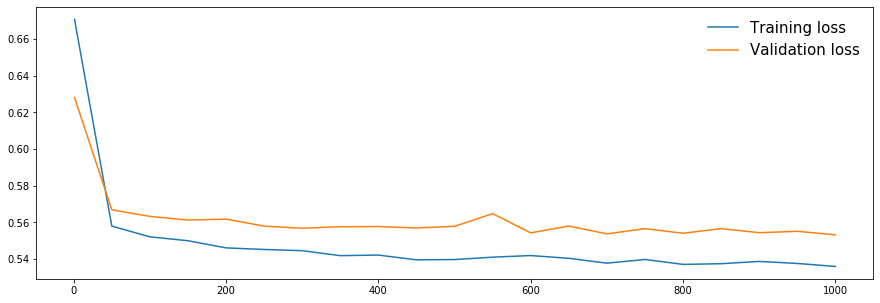

In [9]:
fig = plt.figure(figsize=(15, 5))
plt.plot(x_axis,train_losses, label='Training loss')
plt.plot(x_axis, dev_losses, label='Validation loss')
plt.legend(frameon=False, fontsize=15)
plt.show()

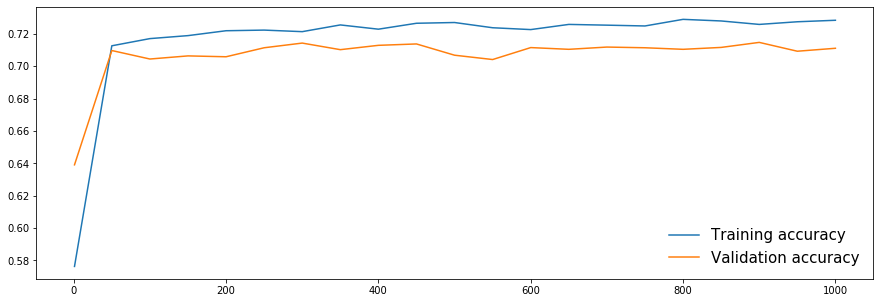

In [10]:
fig = plt.figure(figsize=(15, 5))
plt.plot(x_axis, train_acc, label="Training accuracy")
plt.plot(x_axis, dev_acc, label="Validation accuracy")
plt.legend(frameon=False, fontsize=15)
plt.show()

### Second fine-tuning approach

In [11]:
class Classifier(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.hidden_1 = nn.Linear(input_size, 10)
        self.hidden_2 = nn.Linear(10, 10)
        self.hidden_3 = nn.Linear(10, 10)
        self.hidden_4 = nn.Linear(10, 10)
        self.output = nn.Linear(10, 2)
        
    def forward(self, x):
        z = F.relu(self.hidden_1(x))
        z = F.relu(self.hidden_2(z))
        z = F.relu(self.hidden_3(z))
        z = F.relu(self.hidden_4(z))
        out = F.log_softmax(self.output(z), dim=1)
        
        return out

In [12]:
model = Classifier(X_train.shape[1])
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 1000
batch_size = 128

In [13]:
train_losses, dev_losses, train_acc, dev_acc= [], [], [], []
x_axis = []

for e in range(1, epochs + 1):
    X_, y_ = shuffle(X_train, y_train)
    running_loss = 0
    running_acc = 0
    iterations = 0
    
    for i in range(0, len(X_), batch_size):
        iterations += 1
        b = i + batch_size
        X_batch = torch.tensor(X_.iloc[i:b,:].values).float()
        y_batch = torch.tensor(y_.iloc[i:b].values)
        
        log_ps = model(X_batch)
        loss = criterion(log_ps, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        running_acc += accuracy_score(y_batch, top_class)
        
    dev_loss = 0
    acc = 0

    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        log_dev = model(X_dev_torch)
        dev_loss = criterion(log_dev, y_dev_torch)

        ps_dev = torch.exp(log_dev)
        top_p, top_class_dev = ps_dev.topk(1, dim=1)
        acc = accuracy_score(y_dev_torch, top_class_dev)

    if e%50 == 0 or e == 1:
        x_axis.append(e)
        
        train_losses.append(running_loss/iterations)
        dev_losses.append(dev_loss)
        train_acc.append(running_acc/iterations)
        dev_acc.append(acc)
        
        print("Epoch: {}/{}.. ".format(e, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/iterations),
              "Validation Loss: {:.3f}.. ".format(dev_loss),
              "Training Accuracy: {:.3f}.. ".format(running_acc/iterations),
              "Validation Accuracy: {:.3f}".format(acc))

Epoch: 1/1000..  Training Loss: 0.667..  Validation Loss: 0.619..  Training Accuracy: 0.614..  Validation Accuracy: 0.673
Epoch: 50/1000..  Training Loss: 0.560..  Validation Loss: 0.565..  Training Accuracy: 0.712..  Validation Accuracy: 0.709
Epoch: 100/1000..  Training Loss: 0.553..  Validation Loss: 0.562..  Training Accuracy: 0.718..  Validation Accuracy: 0.710
Epoch: 150/1000..  Training Loss: 0.549..  Validation Loss: 0.564..  Training Accuracy: 0.720..  Validation Accuracy: 0.710
Epoch: 200/1000..  Training Loss: 0.549..  Validation Loss: 0.559..  Training Accuracy: 0.721..  Validation Accuracy: 0.710
Epoch: 250/1000..  Training Loss: 0.545..  Validation Loss: 0.560..  Training Accuracy: 0.723..  Validation Accuracy: 0.708
Epoch: 300/1000..  Training Loss: 0.544..  Validation Loss: 0.558..  Training Accuracy: 0.725..  Validation Accuracy: 0.713
Epoch: 350/1000..  Training Loss: 0.540..  Validation Loss: 0.557..  Training Accuracy: 0.729..  Validation Accuracy: 0.715
Epoch: 400/

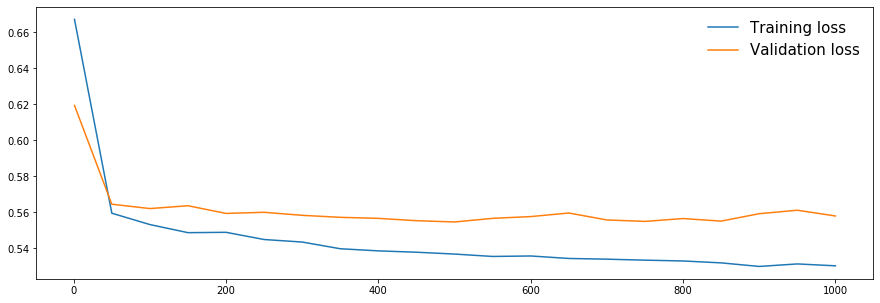

In [14]:
fig = plt.figure(figsize=(15, 5))
plt.plot(x_axis,train_losses, label='Training loss')
plt.plot(x_axis, dev_losses, label='Validation loss')
plt.legend(frameon=False, fontsize=15)
plt.show()

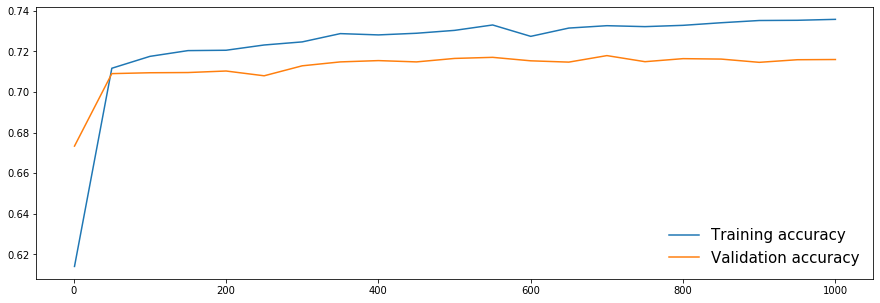

In [15]:
fig = plt.figure(figsize=(15, 5))
plt.plot(x_axis, train_acc, label="Training accuracy")
plt.plot(x_axis, dev_acc, label="Validation accuracy")
plt.legend(frameon=False, fontsize=15)
plt.show()

### Third fine-tuning approach

In [16]:
class Classifier(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.hidden_1 = nn.Linear(input_size, 50)
        self.hidden_2 = nn.Linear(50, 50)
        self.hidden_3 = nn.Linear(50, 50)
        self.hidden_4 = nn.Linear(50, 50)
        self.output = nn.Linear(50, 2)
        
    def forward(self, x):
        z = F.relu(self.hidden_1(x))
        z = F.relu(self.hidden_2(z))
        z = F.relu(self.hidden_3(z))
        z = F.relu(self.hidden_4(z))
        out = F.log_softmax(self.output(z), dim=1)
        
        return out

In [17]:
model = Classifier(X_train.shape[1])
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 1000
batch_size = 128

In [18]:
train_losses, dev_losses, train_acc, dev_acc= [], [], [], []
x_axis = []

for e in range(1, epochs + 1):
    X_, y_ = shuffle(X_train, y_train)
    running_loss = 0
    running_acc = 0
    iterations = 0
    
    for i in range(0, len(X_), batch_size):
        iterations += 1
        b = i + batch_size
        X_batch = torch.tensor(X_.iloc[i:b,:].values).float()
        y_batch = torch.tensor(y_.iloc[i:b].values)
        
        log_ps = model(X_batch)
        loss = criterion(log_ps, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        running_acc += accuracy_score(y_batch, top_class)
        
    dev_loss = 0
    acc = 0

    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        log_dev = model(X_dev_torch)
        dev_loss = criterion(log_dev, y_dev_torch)

        ps_dev = torch.exp(log_dev)
        top_p, top_class_dev = ps_dev.topk(1, dim=1)
        acc = accuracy_score(y_dev_torch, top_class_dev)

    if e%50 == 0 or e == 1:
        x_axis.append(e)
        
        train_losses.append(running_loss/iterations)
        dev_losses.append(dev_loss)
        train_acc.append(running_acc/iterations)
        dev_acc.append(acc)
        
        print("Epoch: {}/{}.. ".format(e, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/iterations),
              "Validation Loss: {:.3f}.. ".format(dev_loss),
              "Training Accuracy: {:.3f}.. ".format(running_acc/iterations),
              "Validation Accuracy: {:.3f}".format(acc))

Epoch: 1/1000..  Training Loss: 0.626..  Validation Loss: 0.595..  Training Accuracy: 0.644..  Validation Accuracy: 0.689
Epoch: 50/1000..  Training Loss: 0.530..  Validation Loss: 0.557..  Training Accuracy: 0.732..  Validation Accuracy: 0.715
Epoch: 100/1000..  Training Loss: 0.497..  Validation Loss: 0.553..  Training Accuracy: 0.754..  Validation Accuracy: 0.718
Epoch: 150/1000..  Training Loss: 0.458..  Validation Loss: 0.576..  Training Accuracy: 0.778..  Validation Accuracy: 0.723
Epoch: 200/1000..  Training Loss: 0.434..  Validation Loss: 0.583..  Training Accuracy: 0.793..  Validation Accuracy: 0.737
Epoch: 250/1000..  Training Loss: 0.440..  Validation Loss: 0.591..  Training Accuracy: 0.790..  Validation Accuracy: 0.741
Epoch: 300/1000..  Training Loss: 0.381..  Validation Loss: 0.624..  Training Accuracy: 0.821..  Validation Accuracy: 0.757
Epoch: 350/1000..  Training Loss: 0.369..  Validation Loss: 0.653..  Training Accuracy: 0.826..  Validation Accuracy: 0.754
Epoch: 400/

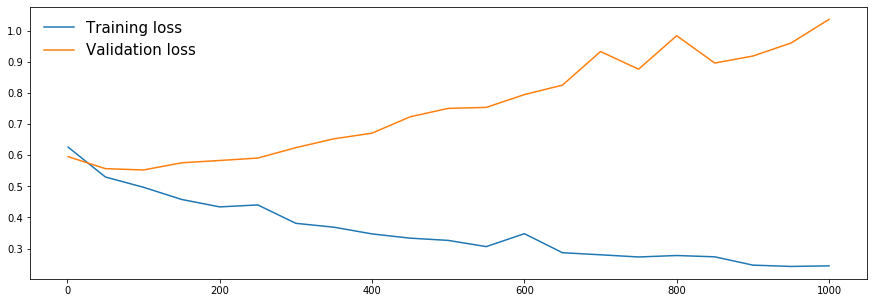

In [19]:
fig = plt.figure(figsize=(15, 5))
plt.plot(x_axis,train_losses, label='Training loss')
plt.plot(x_axis, dev_losses, label='Validation loss')
plt.legend(frameon=False, fontsize=15)
plt.show()

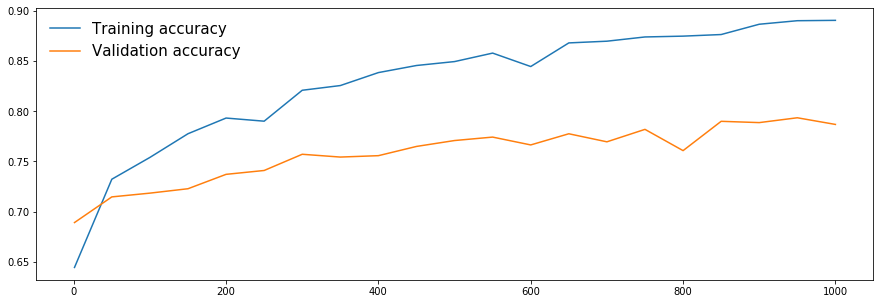

In [20]:
fig = plt.figure(figsize=(15, 5))
plt.plot(x_axis, train_acc, label="Training accuracy")
plt.plot(x_axis, dev_acc, label="Validation accuracy")
plt.legend(frameon=False, fontsize=15)
plt.show()

### Fourth fine-tuning approach

In [21]:
class Classifier(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.hidden_1 = nn.Linear(input_size, 50)
        self.hidden_2 = nn.Linear(50, 50)
        self.hidden_3 = nn.Linear(50, 50)
        self.hidden_4 = nn.Linear(50, 50)
        self.output = nn.Linear(50, 2)
        
        self.dropout = nn.Dropout(p=0.10)
        
    def forward(self, x):
        z = self.dropout(F.relu(self.hidden_1(x)))
        z = self.dropout(F.relu(self.hidden_2(z)))
        z = self.dropout(F.relu(self.hidden_3(z)))
        z = self.dropout(F.relu(self.hidden_4(z)))
        out = F.log_softmax(self.output(z), dim=1)
        
        return out

In [22]:
model = Classifier(X_train.shape[1])
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 2000
batch_size = 128

In [23]:
train_losses, dev_losses, train_acc, dev_acc= [], [], [], []
x_axis = []

for e in range(1, epochs + 1):
    X_, y_ = shuffle(X_train, y_train)
    running_loss = 0
    running_acc = 0
    iterations = 0
    
    for i in range(0, len(X_), batch_size):
        iterations += 1
        b = i + batch_size
        X_batch = torch.tensor(X_.iloc[i:b,:].values).float()
        y_batch = torch.tensor(y_.iloc[i:b].values)
        
        log_ps = model(X_batch)
        loss = criterion(log_ps, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        running_acc += accuracy_score(y_batch, top_class)
        
    dev_loss = 0
    acc = 0

    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        model.eval()
        log_dev = model(X_dev_torch)
        dev_loss = criterion(log_dev, y_dev_torch)

        ps_dev = torch.exp(log_dev)
        top_p, top_class_dev = ps_dev.topk(1, dim=1)
        acc = accuracy_score(y_dev_torch, top_class_dev)
        
    model.train()

    if e%50 == 0 or e == 1:
        x_axis.append(e)
        
        train_losses.append(running_loss/iterations)
        dev_losses.append(dev_loss)
        train_acc.append(running_acc/iterations)
        dev_acc.append(acc)
        
        print("Epoch: {}/{}.. ".format(e, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/iterations),
              "Validation Loss: {:.3f}.. ".format(dev_loss),
              "Training Accuracy: {:.3f}.. ".format(running_acc/iterations),
              "Validation Accuracy: {:.3f}".format(acc))

Epoch: 1/2000..  Training Loss: 0.625..  Validation Loss: 0.594..  Training Accuracy: 0.654..  Validation Accuracy: 0.690
Epoch: 50/2000..  Training Loss: 0.543..  Validation Loss: 0.552..  Training Accuracy: 0.724..  Validation Accuracy: 0.714
Epoch: 100/2000..  Training Loss: 0.529..  Validation Loss: 0.545..  Training Accuracy: 0.732..  Validation Accuracy: 0.718
Epoch: 150/2000..  Training Loss: 0.516..  Validation Loss: 0.542..  Training Accuracy: 0.740..  Validation Accuracy: 0.720
Epoch: 200/2000..  Training Loss: 0.511..  Validation Loss: 0.538..  Training Accuracy: 0.744..  Validation Accuracy: 0.725
Epoch: 250/2000..  Training Loss: 0.504..  Validation Loss: 0.535..  Training Accuracy: 0.750..  Validation Accuracy: 0.726
Epoch: 300/2000..  Training Loss: 0.501..  Validation Loss: 0.532..  Training Accuracy: 0.750..  Validation Accuracy: 0.729
Epoch: 350/2000..  Training Loss: 0.497..  Validation Loss: 0.530..  Training Accuracy: 0.753..  Validation Accuracy: 0.727
Epoch: 400/

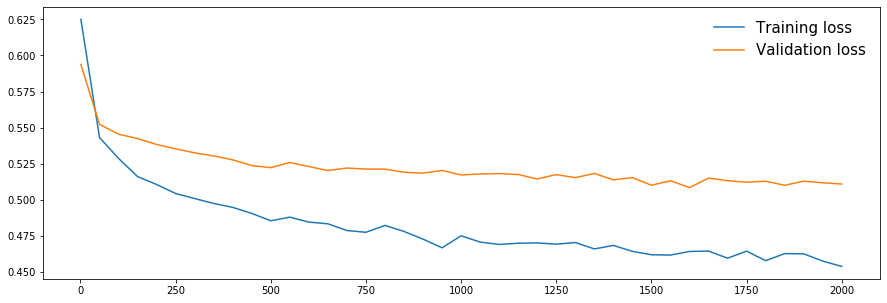

In [24]:
fig = plt.figure(figsize=(15, 5))
plt.plot(x_axis,train_losses, label='Training loss')
plt.plot(x_axis, dev_losses, label='Validation loss')
plt.legend(frameon=False, fontsize=15)
plt.show()

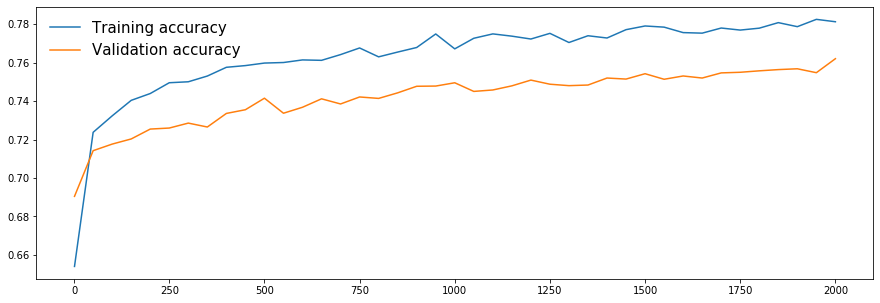

In [25]:
fig = plt.figure(figsize=(15, 5))
plt.plot(x_axis, train_acc, label="Training accuracy")
plt.plot(x_axis, dev_acc, label="Validation accuracy")
plt.legend(frameon=False, fontsize=15)
plt.show()

### After several fine-tuning approaches

In [26]:
class Classifier(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.hidden_1 = nn.Linear(input_size, 100)
        self.hidden_2 = nn.Linear(100, 100)
        self.hidden_3 = nn.Linear(100, 50)
        self.hidden_4 = nn.Linear(50,50)
        self.output = nn.Linear(50, 2)
        
        self.dropout = nn.Dropout(p=0.1)
        
    def forward(self, x):
        z = self.dropout(F.relu(self.hidden_1(x)))
        z = self.dropout(F.relu(self.hidden_2(z)))
        z = self.dropout(F.relu(self.hidden_3(z)))
        z = self.dropout(F.relu(self.hidden_4(z)))
        out = F.log_softmax(self.output(z), dim=1)
        
        return out

In [27]:
model = Classifier(X_train.shape[1])
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 4000
batch_size = 128

In [28]:
train_losses, dev_losses, train_acc, dev_acc= [], [], [], []
x_axis = []

for e in range(1, epochs + 1):
    X_, y_ = shuffle(X_train, y_train)
    running_loss = 0
    running_acc = 0
    iterations = 0
    
    for i in range(0, len(X_), batch_size):
        iterations += 1
        b = i + batch_size
        X_batch = torch.tensor(X_.iloc[i:b,:].values).float()
        y_batch = torch.tensor(y_.iloc[i:b].values)
        
        log_ps = model(X_batch)
        loss = criterion(log_ps, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        running_acc += accuracy_score(y_batch, top_class)
        
    dev_loss = 0
    acc = 0

    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        model.eval()
        log_dev = model(X_dev_torch)
        dev_loss = criterion(log_dev, y_dev_torch)

        ps_dev = torch.exp(log_dev)
        top_p, top_class_dev = ps_dev.topk(1, dim=1)
        acc = accuracy_score(y_dev_torch, top_class_dev)
        
    model.train()

    if e%50 == 0 or e == 1:
        x_axis.append(e)
        
        train_losses.append(running_loss/iterations)
        dev_losses.append(dev_loss)
        train_acc.append(running_acc/iterations)
        dev_acc.append(acc)
        
        print("Epoch: {}/{}.. ".format(e, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/iterations),
              "Validation Loss: {:.3f}.. ".format(dev_loss),
              "Training Accuracy: {:.3f}.. ".format(running_acc/iterations),
              "Validation Accuracy: {:.3f}".format(acc))

Epoch: 1/4000..  Training Loss: 0.620..  Validation Loss: 0.607..  Training Accuracy: 0.655..  Validation Accuracy: 0.665
Epoch: 50/4000..  Training Loss: 0.530..  Validation Loss: 0.549..  Training Accuracy: 0.733..  Validation Accuracy: 0.720
Epoch: 100/4000..  Training Loss: 0.500..  Validation Loss: 0.536..  Training Accuracy: 0.754..  Validation Accuracy: 0.732
Epoch: 150/4000..  Training Loss: 0.474..  Validation Loss: 0.521..  Training Accuracy: 0.770..  Validation Accuracy: 0.739
Epoch: 200/4000..  Training Loss: 0.463..  Validation Loss: 0.517..  Training Accuracy: 0.775..  Validation Accuracy: 0.750
Epoch: 250/4000..  Training Loss: 0.457..  Validation Loss: 0.509..  Training Accuracy: 0.778..  Validation Accuracy: 0.751
Epoch: 300/4000..  Training Loss: 0.445..  Validation Loss: 0.508..  Training Accuracy: 0.784..  Validation Accuracy: 0.753
Epoch: 350/4000..  Training Loss: 0.431..  Validation Loss: 0.502..  Training Accuracy: 0.790..  Validation Accuracy: 0.760
Epoch: 400/

Epoch: 3300/4000..  Training Loss: 0.356..  Validation Loss: 0.475..  Training Accuracy: 0.836..  Validation Accuracy: 0.797
Epoch: 3350/4000..  Training Loss: 0.353..  Validation Loss: 0.480..  Training Accuracy: 0.838..  Validation Accuracy: 0.800
Epoch: 3400/4000..  Training Loss: 0.354..  Validation Loss: 0.474..  Training Accuracy: 0.840..  Validation Accuracy: 0.796
Epoch: 3450/4000..  Training Loss: 0.351..  Validation Loss: 0.477..  Training Accuracy: 0.842..  Validation Accuracy: 0.800
Epoch: 3500/4000..  Training Loss: 0.353..  Validation Loss: 0.474..  Training Accuracy: 0.839..  Validation Accuracy: 0.800
Epoch: 3550/4000..  Training Loss: 0.353..  Validation Loss: 0.468..  Training Accuracy: 0.842..  Validation Accuracy: 0.801
Epoch: 3600/4000..  Training Loss: 0.348..  Validation Loss: 0.477..  Training Accuracy: 0.843..  Validation Accuracy: 0.801
Epoch: 3650/4000..  Training Loss: 0.353..  Validation Loss: 0.468..  Training Accuracy: 0.841..  Validation Accuracy: 0.803


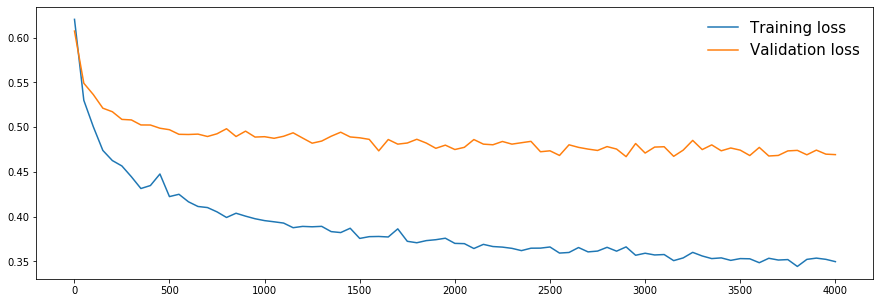

In [29]:
fig = plt.figure(figsize=(15, 5))
plt.plot(x_axis,train_losses, label='Training loss')
plt.plot(x_axis, dev_losses, label='Validation loss')
plt.legend(frameon=False, fontsize=15)
plt.show()

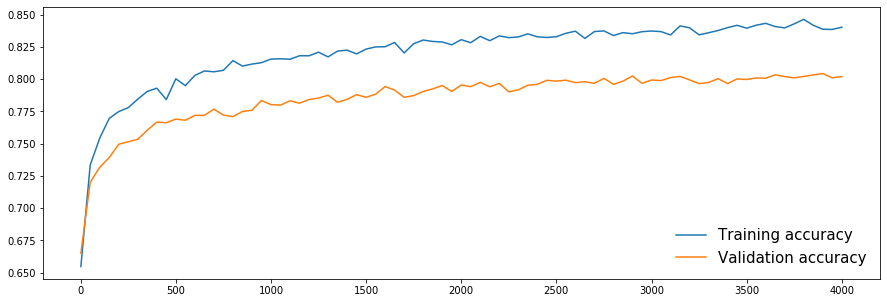

In [30]:
fig = plt.figure(figsize=(15, 5))
plt.plot(x_axis, train_acc, label="Training accuracy")
plt.plot(x_axis, dev_acc, label="Validation accuracy")
plt.legend(frameon=False, fontsize=15)
plt.show()

In [31]:
model.eval()
test_pred = model(X_test_torch)
test_pred = torch.exp(test_pred)
top_p, top_class_test = test_pred.topk(1, dim=1)
acc_test = accuracy_score(y_test_torch, top_class_test)
print(acc_test)

0.8079392253370425


## ACTIVITY 3

In [32]:
checkpoint = {"input": X_train.shape[1],
              "state_dict": model.state_dict()}

In [33]:
torch.save(checkpoint, "checkpoint.pth")